<a href="https://colab.research.google.com/github/Mahshad-RM/MOR/blob/main/Assignments_overview_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*
     import dlroms.fespaces as fe

# **Assignments overview - Part 1**

This notebook contains a brief overview of three assignments related to the first part of the course.

**NB**: if you are using Colab to run this notebook, make sure to upload the scripts $\textsf{dispenser.py}$, $\textsf{playground.py}$ and $\textsf{electron.py}$ to the notebook environment ("Folder" icon on your left, near the "Key" icon). If you are working locally, instead, make sure that those scripts are in the same folder of the notebook.

## **Convection-diffusion equation**: designing a chemical dispenser

In [27]:
import numpy as np
import importlib
import dispenser
importlib.reload(dispenser)

from dispenser import FOMsolver, FOMsolverhom, Vh, Vb, compute_basis_functions

In [22]:
# Compute basis functions
b1, b2, b3 = compute_basis_functions()
dispenser.b1 = b1  # Make b1, b2, b3 available in dispenser.py
dispenser.b2 = b2
dispenser.b3 = b3

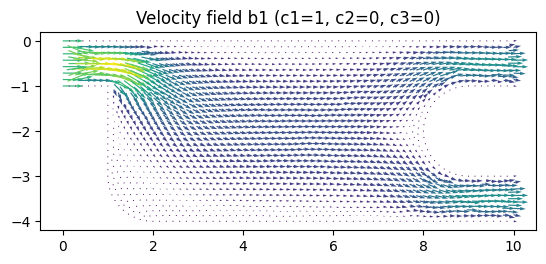

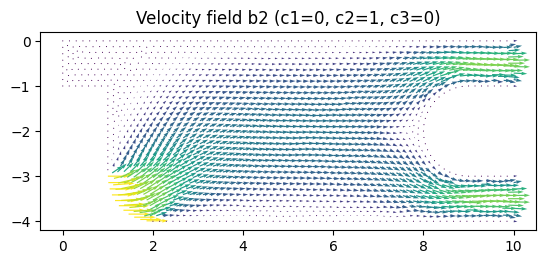

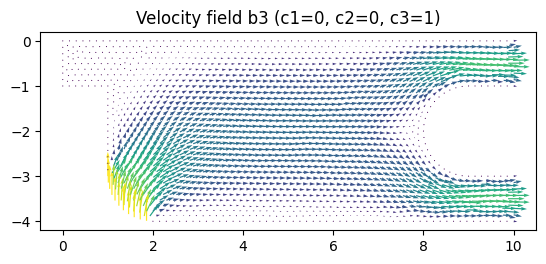

In [20]:
import matplotlib.pyplot as plt
from fenics import plot

# Convert to FEniCS Function for plotting
bf1 = fe.asfunction(b1, Vb)
bf2 = fe.asfunction(b2, Vb)
bf3 = fe.asfunction(b3, Vb)

# Plot b1
plt.figure()
plot(bf1, title="Velocity field b1 (c1=1, c2=0, c3=0)")
plt.show()

# Plot b2
plt.figure()
plot(bf2, title="Velocity field b2 (c1=0, c2=1, c3=0)")
plt.show()

# Plot b3
plt.figure()
plot(bf3, title="Velocity field b3 (c1=0, c2=0, c3=1)")
plt.show()


In [23]:
u = FOMsolver(40, 20, 30)
u.shape


(701, 1940)

In [24]:
u_hom=FOMsolverhom(40,20,30)
u_hom.shape

(701, 1940)

In [28]:
# Verify that u = uₕₒₘ + 1
error = np.max(np.abs(u - (u_hom + 1)))
print(f"Maximum error between u and uₕₒₘ + 1: {error}")

Maximum error between u and uₕₒₘ + 1: 0.007160849108533041


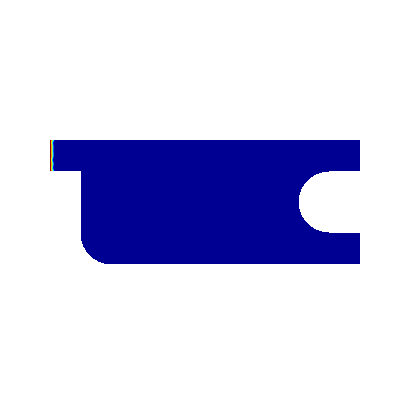

In [7]:
fe.animate(u[::10], Vh)

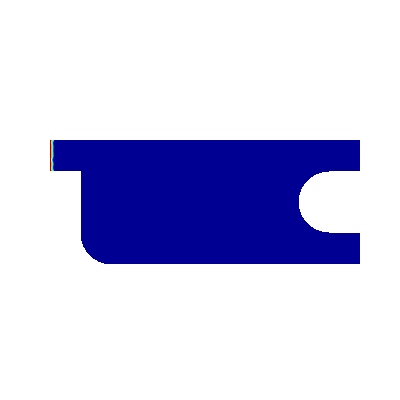

In [29]:
fe.animate(u_hom[::10], Vh)

In [ ]:
from dispenser import bottomOutflow

print(bottomOutflow(u))

0.022940463063376885
